# 机器学习工程师纳米学位
## 深度学习
## 项目：搭建一个数字识别项目

在此文件中，我们提供给你了一个模板，以便于你根据项目的要求一步步实现要求的功能，进而完成整个项目。如果你认为需要导入另外的一些代码，请确保你正确导入了他们，并且包含在你的提交文件中。以**'练习'**开始的标题表示接下来你将开始实现你的项目。注意有一些练习是可选的，并且用**'可选'**标记出来了。

在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以'练习'开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。

>**注意：** Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 连接 mnist 的字符来合成数据

你可以通过连接[MNIST](http://yann.lecun.com/exdb/mnist/)的字符来合成数据来训练这个模型。为了快速导入数据集，我们可以使用 [Keras Datasets](https://keras.io/datasets/#mnist-database-of-handwritten-digits) [中文文档](http://keras-cn.readthedocs.io/en/latest/other/datasets/#mnist)。

### 载入 mnist

In [45]:
from keras.datasets import mnist

(X_raw, y_raw), (X_raw_test, y_raw_test) = mnist.load_data()

n_train, n_test = X_raw.shape[0], X_raw_test.shape[0]

fpath:/Users/michaelfeng/.keras/datasets/mnist.npz


### 可视化 mnist

我们可以通过 matplotlib 来可视化我们的原始数据集。

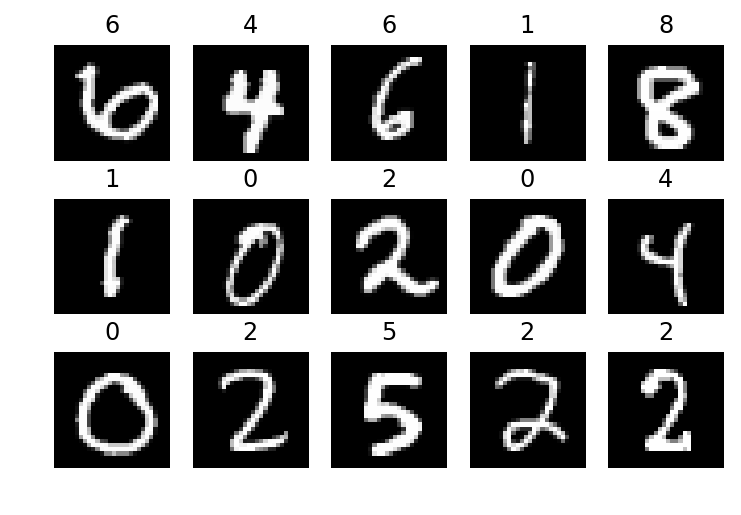

In [46]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

for i in range(15):
    plt.subplot(3, 5, i+1)
    index = random.randint(0, n_train-1)
    plt.title(str(y_raw[index]))
    plt.imshow(X_raw[index], cmap='gray')
    plt.axis('off')

### 练习：合成数据

你需要随机取随机张图片，然后将它们拼接成新的图片。


In [47]:
import numpy as np

n_class, n_len, width, height = 11, 5, 28, 28

def generate_dataset(X, y):
    X_len = X.shape[0]
    X_gen = np.zeros((X_len, height, width*n_len, 1), dtype=np.uint8)
    y_gen = [np.zeros((X_len, n_class), dtype=np.uint8) for i in range(n_len)]
    # TODO: 随机取1~5个数字，并拼接成新的图片  
    for index in range(X_len):        
        digits = random.randint(1, 5)    
        for i in range(digits):
            j = random.randint(0, X_len-1)   
            X_gen[index,:,i*width:(i+1)*width,0] = X[j]
            y_gen[i][index][y[j]] = 1
        for i in range(digits, n_len):
            y_gen[i][index][10] = 1
 
    return X_gen, y_gen

X_train, y_train = generate_dataset(X_raw, y_raw)
X_test, y_test = generate_dataset(X_raw_test, y_raw_test)

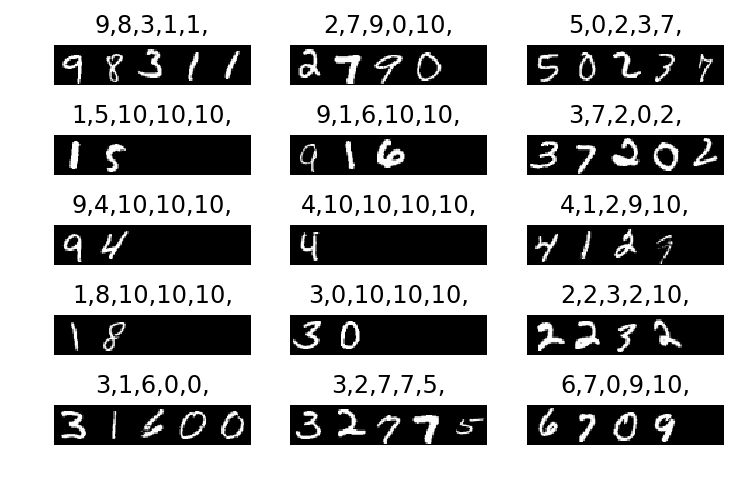

In [48]:
# 显示生成的图片
for i in range(15):
    plt.subplot(5, 3, i+1)
    index = random.randint(0, n_test-1)
    title = ''
    for j in range(n_len):
        title += str(np.argmax(y_test[j][index])) + ','
    
    plt.title(title)
    plt.imshow(X_test[index][:,:,0], cmap='gray')
    plt.axis('off')

### 问题 1
_你是如何合成数据集的？_

**回答：**

需要将原始训练集和测试集的每一个数字与其他随机取出的不超过4个数字进行拼接，形成一个不超过5个数字的序列

- 对传入的数据集的每一个数字，先随机一个不超过5的数字作为这一数字序列的长度
- 针对上一步随机生成的数值位数的每一位，从原始数据集随机提取一个数字对应的下标，然后利用slicing将X中的该图片对应的矩阵填充到这一数位对应的数字中，对应的label标记为1
- 最后针对不足5位的X值（空图片）对应的label填充数字为10


### 练习：设计并测试一个模型架构

设计并实现一个能够识别数字序列的深度学习模型。为了产生用于测试的合成数字序列，你可以进行如下的设置：比如，你可以限制一个数据序列最多五个数字，并在你的深度网络上使用五个分类器。同时，你有必要准备一个额外的“空白”的字符，以处理相对较短的数字序列。

在思考这个问题的时候有很多方面可以考虑：

- 你的模型可以基于深度神经网络或者是卷积神经网络。
- 你可以尝试是否在每个分类器间共享权值。
- 你还可以在深度神经网络中使用循环网络来替换其中的分类层，并且将数字序列里的数字一个一个地输出。

在使用 Keras 搭建模型的时候，你可以使用 [泛型模型](http://keras-cn.readthedocs.io/en/latest/models/model/) 的方式来搭建多输出模型。

In [50]:
from keras.models import Model
from keras.layers import *
from keras.models import Sequential

# TODO: 构建你的模型
seed = 7
np.random.seed(seed)

def train_model():
    a = Input((28, 28*5, 1))
    b = Conv2D(30, (3, 3), padding='same', activation='relu')(a)
    b = Conv2D(30, (3, 3), padding='same', activation='relu')(b)
    b = MaxPooling2D(pool_size=(2, 2), padding='same')(b)
    b = Conv2D(15, (3, 3), padding='same', activation='relu')(b)
    b = Conv2D(15, (3, 3), padding='same', activation='relu')(b)
    b = MaxPooling2D(pool_size=(2, 2), padding='same')(b)    
    b = Flatten()(b)
    b = Dropout(0.2)(b)
    lst_output = [Dense(11, activation='softmax')(b) for i in range(n_len)]
    model = Model(inputs=a, outputs=lst_output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### 问题 2
_你为解决这个问题采取了什么技术？请详细介绍你使用的技术。_

**回答：** 

- 卷积层:用来提取输入的图片的特征，将原始数据映射到隐藏层的特征空间
- 使用ReLU作为激活函数:用来增强判定函数和整个神经网络的非线性特性，相较于其他的激活函数而言，ReLU求导速度快，所以可以将神经网络的训练速度提升,而不会对模型的泛化造成显著影响此外，ReLU解决了Sigmoid激活函数会出现的梯度消失的问题
- Flatten：通过将二维的矩阵数据转换为向量，使得后续的数据可以被全连接层更好的处理
- Dropout：随机的抛弃该层的20%的神经元来防止过拟合
- softmax：针对每一个数字输出对应的概率，而且针对其中概率最大的数值，相对于其他的数值，softmax会增大其概率，并且在此基础之上保证所有的数值概率之和为1。
- 最大池化：将输入的图像划分为若干个2*2的矩形区域后对每个矩形区域输出最大值，用来减小数据的空间大小，此外一定程度上也防止了过拟合
- 使用Adam作为优化器的优化算法，该算法效率较高

### 可视化你的网络模型

参考链接：[visualization](http://keras-cn.readthedocs.io/en/latest/other/visualization/)

可以是 PNG 格式，也可以是 SVG 格式。

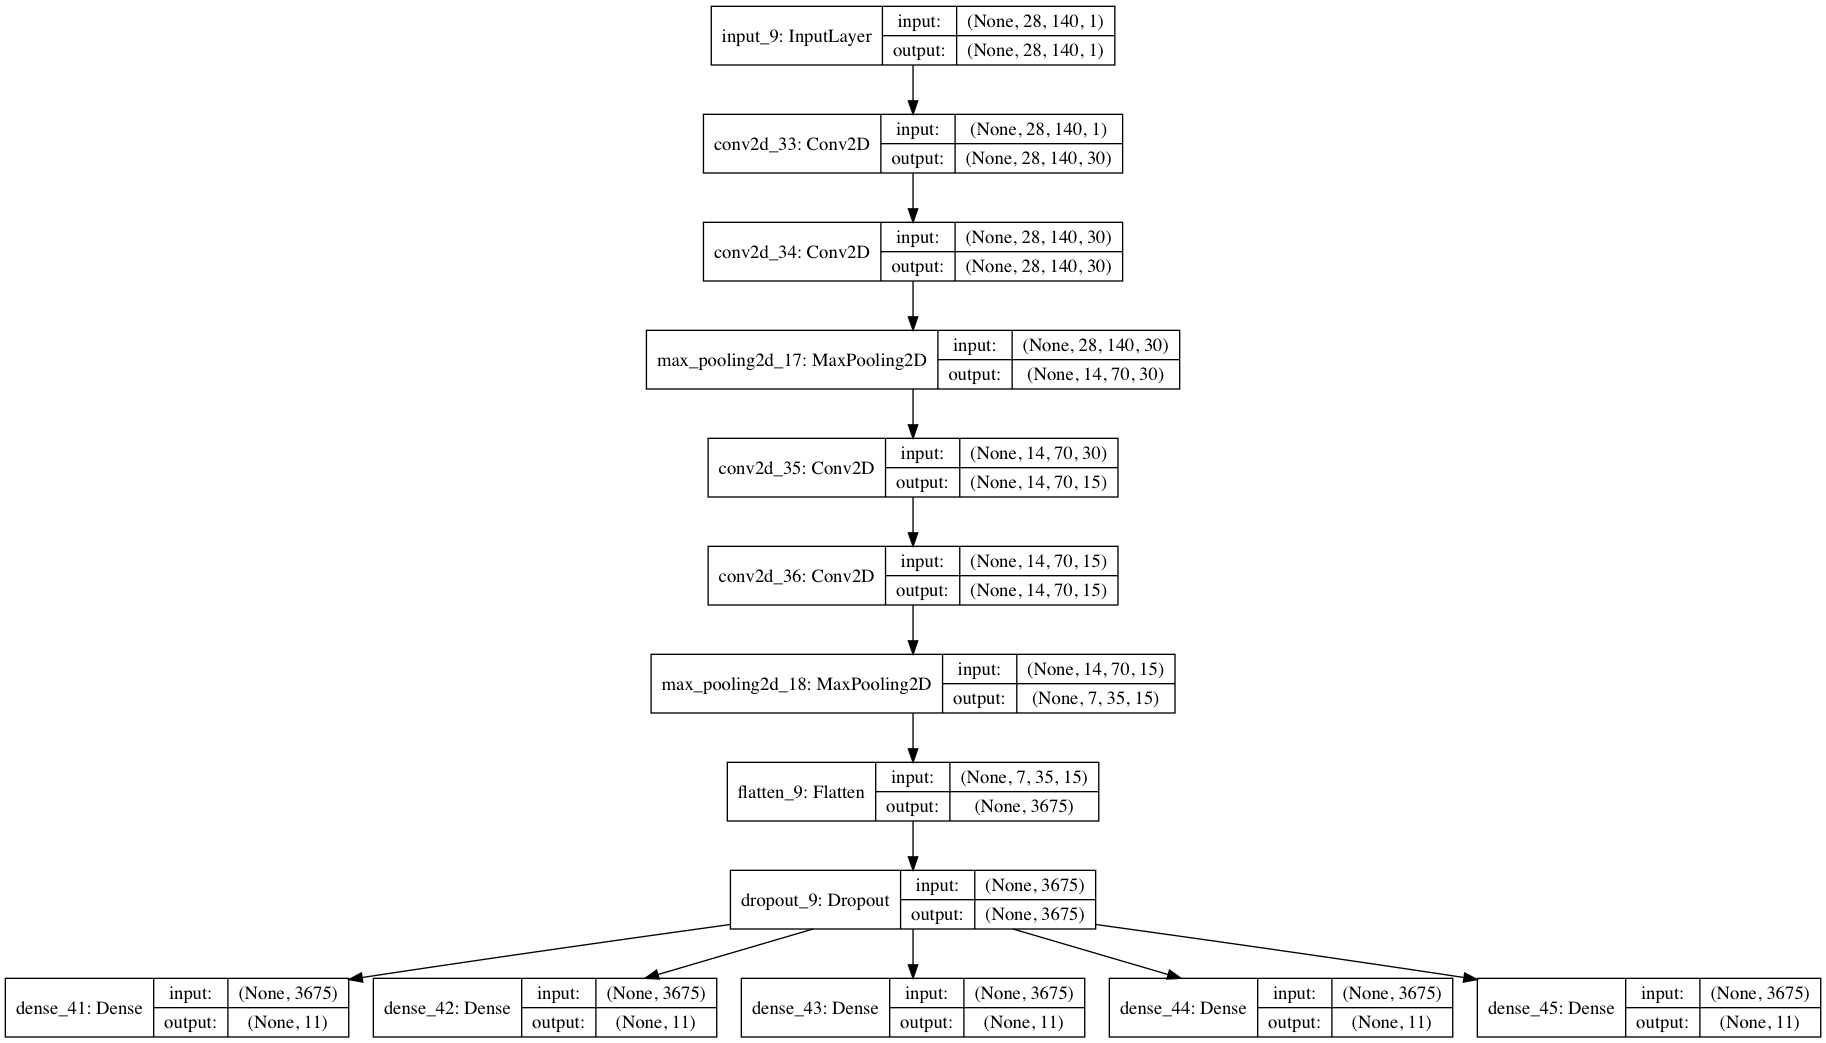

In [51]:
# from keras.utils.visualize_util import plot, model_to_dot
from keras.utils import plot_model
from IPython.display import Image, SVG

# TODO: 可视化你的模型
model = train_model()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

Image(filename = 'model.png')

### 问题 3
_你最终的模型架构是什么样的？（什么类型的模型，层数，大小, 如何连接等）_

**回答：**

- Sequential模型
- 不含输入层的话一共有九层，其中
- 第一层为30个卷积核，3行3列的卷积层，直接连接输入层和下一层
- 第二层为30个卷积核，3行3列的卷积层，直接连接上一个卷积层和下一层
- 第三层为2*2的最大池化层，直接与上一层卷积层相连
- 第四层为15个卷积核，3行3列的卷积层，同样是直接与上一层相连
- 第五层为15个卷积核，3行3列的卷积层，同样是直接与上一层相连
- 第六层为2*2的最大池化层，直接与上一层卷积层相连
- 第七层为Flatten层
- 第八层为Dropout层
- 第九层为5个全连接层，与上一层直接相连，作为输出层

### 练习：训练你的网络模型

你需要设置20%的数据作为验证集，以保证模型没有过拟合。

In [57]:
# TODO: 训练你的模型
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=2)
log = model.fit(X_train, [label for label in y_train], epochs=25, validation_split=0.2, batch_size=2000, verbose=2,
               callbacks=[early_stop])

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
453s - loss: 0.2531 - dense_41_loss: 0.0793 - dense_42_loss: 0.0654 - dense_43_loss: 0.0520 - dense_44_loss: 0.0374 - dense_45_loss: 0.0191 - dense_41_acc: 0.9748 - dense_42_acc: 0.9789 - dense_43_acc: 0.9828 - dense_44_acc: 0.9878 - dense_45_acc: 0.9939 - val_loss: 0.2345 - val_dense_41_loss: 0.0707 - val_dense_42_loss: 0.0540 - val_dense_43_loss: 0.0552 - val_dense_44_loss: 0.0355 - val_dense_45_loss: 0.0191 - val_dense_41_acc: 0.9786 - val_dense_42_acc: 0.9836 - val_dense_43_acc: 0.9821 - val_dense_44_acc: 0.9880 - val_dense_45_acc: 0.9940
Epoch 2/25
451s - loss: 0.1815 - dense_41_loss: 0.0590 - dense_42_loss: 0.0463 - dense_43_loss: 0.0373 - dense_44_loss: 0.0288 - dense_45_loss: 0.0101 - dense_41_acc: 0.9808 - dense_42_acc: 0.9841 - dense_43_acc: 0.9882 - dense_44_acc: 0.9905 - dense_45_acc: 0.9967 - val_loss: 0.2201 - val_dense_41_loss: 0.0610 - val_dense_42_loss: 0.0479 - val_dense_43_loss: 0.0465 - val_dense_44_loss: 

### 练习：计算你的模型准确率

我们刚才得到了模型每个数字的准确率，现在让我们来计算整体准确率，按照完全预测正确数字序列的标准来计算。

比如 1,2,3,10,10 预测成了 1,2,10,10,10 算错，而不是算对了80%。

In [58]:
def evaluate(model):
    # TODO: 按照错一个就算错的规则计算准确率
    y_pred = model.predict(X_test, batch_size=1000)
    pred = np.argmax(y_pred, axis=2)
    test = np.argmax(y_test, axis=2)
    accuracy = np.min((pred==test), axis=0).mean()
    return accuracy

evaluate(model)

0.94140000000000001

### 问题 4

_你的模型准确率有多少？你觉得你的模型足以解决问题吗？_

**回答：**

模型准确率为0.9428，在原始模型的基础上替换一层卷积层为3*3并额外增加了两层卷积层，此外在训练数据集时添加了callback中的earlyStopping操作是模型在针对验证集没有明显的改善时结束训练，针对该数据应该是有不错的效果，但是如果放到现实中的图片识别，恐怕还需要对数据进行更多的预处理以及模型优化操作

### 预测值可视化

我们将模型的预测结果和真实值画出来，观察真实效果。

(-0.5, 139.5, 27.5, -0.5)

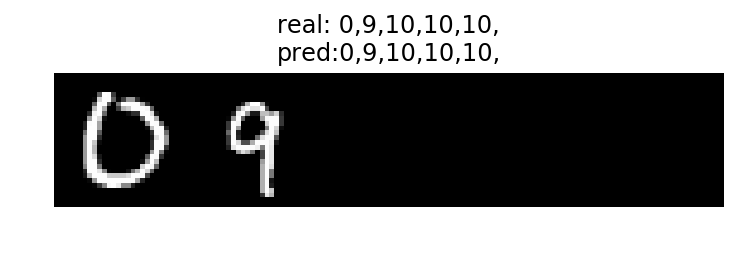

In [35]:
def get_result(result):
    # 将 one_hot 编码解码
    resultstr = ''
    for i in range(n_len):
        resultstr += str(np.argmax(result[i])) + ','
    return resultstr

index = random.randint(0, n_test-1)
y_pred = model.predict(X_test[index].reshape(1, height, width*n_len, 1))

plt.title('real: %s\npred:%s'%(get_result([y_test[x][index] for x in range(n_len)]), get_result(y_pred)))
plt.imshow(X_test[index,:,:,0], cmap='gray')
plt.axis('off')

### 保存模型

模型达到满意的效果以后，我们需要将模型的权值和结构保存，以便下次调用。

In [18]:
model.save_weights('model.h5')
with open('model.json', 'w') as f:
    f.write(model.to_json())